<a href="https://colab.research.google.com/github/hardiksharma2005/Reddit-Post-Classifier/blob/main/Reddit_Post_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=f18f2748e3fc2ee851d2c6c6f677948e884348e349d0e598697e1427c0d62ec2
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [2]:
import pandas as pd
import pandasql as ps

Loading the data

In [3]:
df = pd.read_csv("reddit data.csv")
df.head()

/tmp/ipython-input-3204718295.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reddit data.csv")


,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,ll1p9h,Wordcloud of trending video titles on YouTube ...,1,OmarZiada,OC: 1,NaN,0.0,[],1613473961,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,ll1o4h,Wordcloud of trending videos on YouTube in the...,1,OmarZiada,OC: 1,moderator,0.0,[],1613473829,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
2,ll15gx,Immunization in India. Source: https://niti.go...,1,Professional_Napper_,NaN,moderator,0.0,[],1613471541,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
3,ll0iup,How to quickly estimate the impact of players ...,1,Viziball,NaN,automod_filtered,0.0,[],1613468624,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,ll0g9a,How to quickly estimate the impact of players ...,1,Viziball,NaN,moderator,0.0,[],1613468281,https://www.reddit.com/r/dataisbeautiful/comme...,2,False


Day 1: SQL Analysis using PandaSQL

In [4]:
if 'over_18' in df.columns:
    df['category'] = df['over_18'].apply(lambda x: 'NSFW' if x == True else 'Safe')
    print("created 'category' column for SQL analysis")
else:
    print("Column 'over_18' not found")
    df['category'] = 'Unknown'

created 'category' column for SQL analysis


In [5]:
#Insight: Do NSFW posts get higher scores than Safe posts?
print("\n Average Score by Category")
q1 = """
SELECT category, COUNT(*) as post_count, AVG(score) as avg_score
FROM df
GROUP BY category
ORDER BY avg_score DESC
"""
ps.sqldf(q1, locals())


 Average Score by Category


,category,post_count,avg_score
0,NSFW,1068,583.908240
1,Safe,189785,173.720779


In [6]:
# Insight: Classifying posts into 'Viral', 'Hot', or 'Normal' based on score
print("\n Viral post classification")
q2 = """
SELECT title, score,
       CASE
           WHEN score > 5000 THEN 'Viral'
           WHEN score > 1000 THEN 'Hot'
           ELSE 'Normal'
       END as virality_label
FROM df
LIMIT 5
"""
ps.sqldf(q2, locals())


 Viral post classification


,title,score,virality_label
0,Wordcloud of trending video titles on YouTube ...,1,Normal
1,Wordcloud of trending videos on YouTube in the...,1,Normal
2,Immunization in India. Source: https://niti.go...,1,Normal
3,How to quickly estimate the impact of players ...,1,Normal
4,How to quickly estimate the impact of players ...,1,Normal


In [7]:
# Insight: Find the #1 highest ranked post within each category (Safe vs NSFW)
print("\n Top post per category (Window Function)")
q3 = """
SELECT title, category, score,
       RANK() OVER (PARTITION BY category ORDER BY score DESC) as rank
FROM df
LIMIT 10
"""
ps.sqldf(q3, locals())


 Top post per category (Window Function)


,title,category,score,rank
0,"Pornhub traffic in Hawaii during the ""missile ...",NSFW,63569,1
1,Tinder over 3 years (18-21 Male) [OC],NSFW,59130,2
2,"""Fuuuuck"", orthographic repetition on Twitter ...",NSFW,38419,3
3,Six months on tinder as a young sex worker loo...,NSFW,34248,4
4,Reddit's favorite swear word is 'shit'; the su...,NSFW,31961,5
5,Pornhub’s year in review,NSFW,25833,6
6,[oc] How taboo and popular are sexual fetishes...,NSFW,25715,7
7,NSFW Heat Map of Reddit's Favorite Porn Cross-...,NSFW,24508,8
8,"On /r/gonewild, 18 year-olds rule [OC]",NSFW,18618,9
9,Playboy’s Cover Girls’ Hair Colors — statistic...,NSFW,17578,10


Data Analysis (EDA)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style("whitegrid")

/tmp/ipython-input-1435078278.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['over_18'].astype(str), palette='coolwarm')


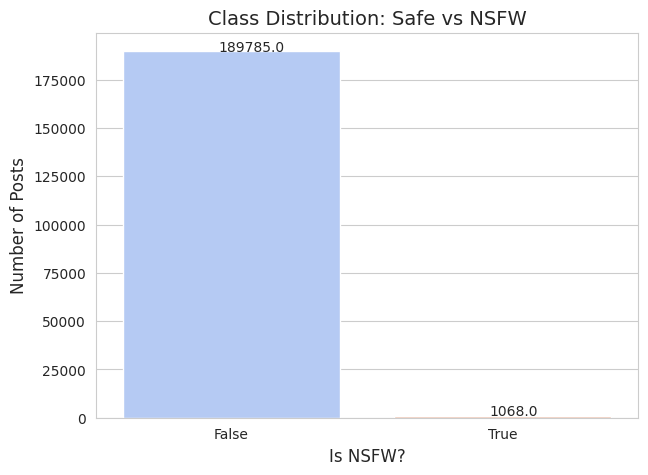

In [9]:
# 1. CLASS IMBALANCE CHECK
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=df['over_18'].astype(str), palette='coolwarm')
plt.title('Class Distribution: Safe vs NSFW', fontsize=14)
plt.xlabel('Is NSFW?', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Add labels to bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.35, p.get_height() + 5))
plt.show()

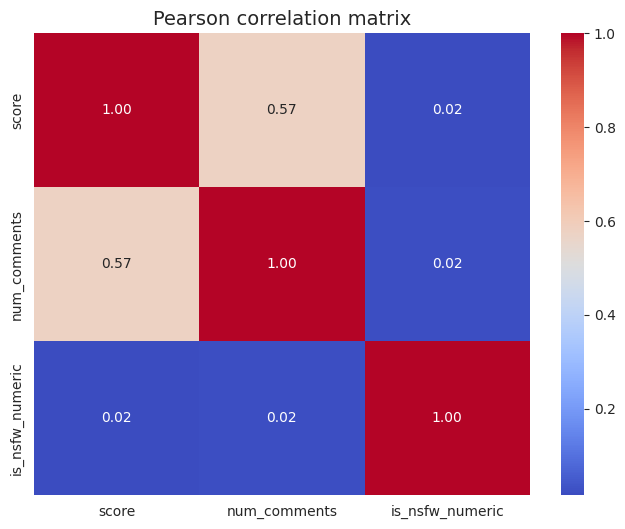

In [10]:
# 2. CORRELATION HEATMAP
# We check relationships between Score, Comments, and NSFW status.
plt.figure(figsize=(8, 6))
# Convert boolean 'over_18' to integer (0 or 1) for correlation
df['is_nsfw_numeric'] = df['over_18'].astype(int)
numeric_cols = df[['score', 'num_comments', 'is_nsfw_numeric']]

sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson correlation matrix', fontsize=14)
plt.show()

Text(0.5, 1.0, 'common words in SAFE posts')

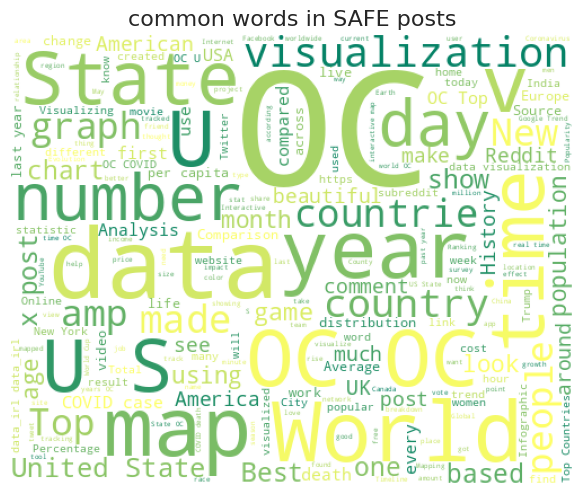

In [11]:
# 3. COMPARATIVE WORD CLOUDS
# We separate the text to see what words trigger the "NSFW" label.
safe_text = " ".join(df[df['over_18'] == False]['title'].astype(str))
nsfw_text = " ".join(df[df['over_18'] == True]['title'].astype(str))

plt.figure(figsize=(16, 8))

# Safe Word Cloud
plt.subplot(1, 2, 1)
wc_safe = WordCloud(width=500, height=400, background_color='white', colormap='summer').generate(safe_text)
plt.imshow(wc_safe)
plt.axis('off')
plt.title('common words in SAFE posts', fontsize=16)

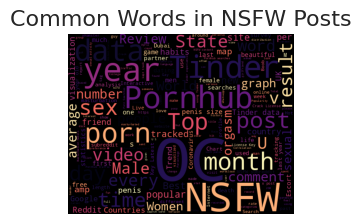

In [12]:
# NSFW Word Cloud
plt.subplot(1, 2, 2)
wc_nsfw = WordCloud(width=500, height=400, background_color='black', colormap='magma').generate(nsfw_text)
plt.imshow(wc_nsfw)
plt.axis('off')
plt.title('Common Words in NSFW Posts', fontsize=16)

plt.show()

NLP Preprocessing

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
if len(df) > 20000:
    print(f"({len(df)} rows) Downsampling")
    df_small = df.sample(n=20000, random_state=42).copy()
else:
    df_small = df.copy()

(190853 rows) Downsampling


In [15]:
# 2. TEXT CLEANING
df_small['clean_title'] = df_small['title'].astype(str)

In [16]:
# 3. SPARSE VECTORIZATION
print("Vectorizing text")
tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X = tfidf.fit_transform(df_small['clean_title'])
y = df_small['over_18']

print(f"Matrix shape: {X.shape}")

Vectorizing text
Matrix shape: (20000, 3000)


Model Training

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

Day 4 Handling imbalance data and model training

In [18]:
# 1. SEPARATE THE CLASSES
df_safe = df[df['over_18'] == False]
df_nsfw = df[df['over_18'] == True]

print(f"Safe counts: {len(df_safe)}, NSFW counts: {len(df_nsfw)}")

Safe counts: 189785, NSFW counts: 1068


In [19]:
# 2. DOWNSAMPLE THE MAJORITY (SAFE)
df_safe_downsampled = resample(df_safe,
                               replace=False,    # sample without replacement
                               n_samples=len(df_nsfw), # match minority count
                               random_state=42)

In [20]:
# 3. COMBINE BACK TOGETHER
df_balanced = pd.concat([df_safe_downsampled, df_nsfw])

print(f"balanced dataset created {len(df_balanced)} rows total")
print(df_balanced['over_18'].value_counts())

balanced dataset created 2136 rows total
over_18
False    1068
True     1068
Name: count, dtype: int64


In [21]:
# 4. VECTORIZE THE BALANCED DATA
print("re vectorization of balanced data")
tfidf_balanced = TfidfVectorizer(max_features=3000, stop_words='english')
# Ensure text is string
df_balanced['clean_title'] = df_balanced['title'].astype(str)

X_bal = tfidf_balanced.fit_transform(df_balanced['clean_title'])
y_bal = df_balanced['over_18']

re vectorization of balanced data


In [22]:
# 5. SPLIT & TRAIN
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

print("Random Forest training")
rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
rf_balanced.fit(X_train_b, y_train_b)
y_pred_b = rf_balanced.predict(X_test_b)

print("Random Forest performance")
print(classification_report(y_test_b, y_pred_b))

Random Forest training
Random Forest performance
              precision    recall  f1-score   support

       False       0.70      0.94      0.81       216
        True       0.91      0.59      0.72       212

    accuracy                           0.77       428
   macro avg       0.81      0.77      0.76       428
weighted avg       0.81      0.77      0.76       428



In [23]:
# 6. Train Decision Tree
print("Training Decision Tree")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_b, y_train_b)
y_pred_dt = dt_model.predict(X_test_b)

print("Decision Tree performance")
print(classification_report(y_test_b, y_pred_dt))

Training Decision Tree
Decision Tree performance
              precision    recall  f1-score   support

       False       0.74      0.81      0.78       216
        True       0.79      0.71      0.75       212

    accuracy                           0.76       428
   macro avg       0.77      0.76      0.76       428
weighted avg       0.77      0.76      0.76       428



Day 5 corelation matrix

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [25]:
# 1. Generating The MATRIX
cm = confusion_matrix(y_test_b, y_pred_b)


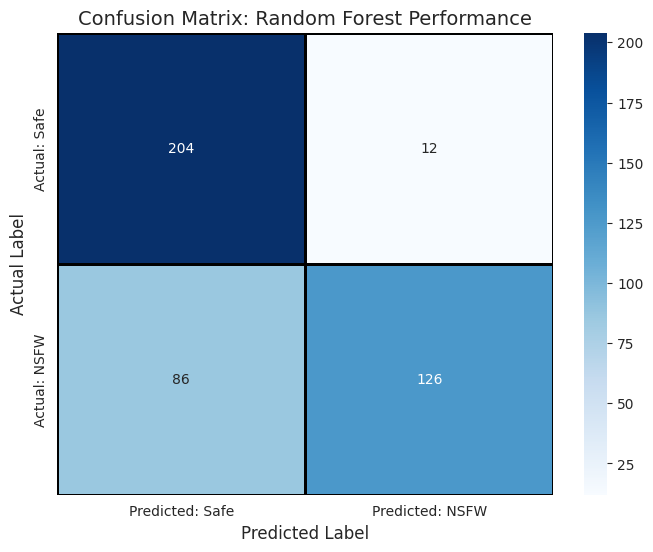

In [26]:
# 2. PLOT THE HEATMAP
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black',
            xticklabels=['Predicted: Safe', 'Predicted: NSFW'],
            yticklabels=['Actual: Safe', 'Actual: NSFW'])

plt.title('Confusion Matrix: Random Forest Performance', fontsize=14)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

Day 6 Gemini API

In [27]:
!pip install -q -U google-genai
from google import genai
import time
from google.colab import userdata
import numpy as np
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 14.0 MB/s eta 0:00:00


In [28]:
API_KEY = userdata.get('GOOGLE_API_KEY')

client = genai.Client(api_key=API_KEY)
print("API configured")


API configured


In [29]:
#isolating the hard cases
import numpy as np

# sparse matrix fix
y_test_arr = np.array(y_test_b)
y_pred_arr = np.array(y_pred_b)

mask = (y_test_arr == True) & (y_pred_arr == False)

# filtering the dataFrame indices
failure_indices = y_test_b.index[mask]
hard_cases = df_balanced.loc[failure_indices].head(5)

In [30]:
def ask_gemini(post_title):
    prompt = f"""
    Analyze the following Reddit post title for NSFW (Not Safe For Work) content.
    Title: "{post_title}"

    Steps:
    1. Identify slang, innuendo, or explicit keywords.
    2. Determine user intent.
    3. Classify as 'NSFW' or 'Safe'.

    Output strictly in this format:
    Classification: [NSFW/Safe]
    Reasoning: [One sentence explanation]
    """

    try:
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            contents=prompt
        )
        return response.text.strip()
    except Exception as e:
        return f"Error: {e}"

In [31]:
#running the test
print("Starting Gemini Analysis\n")
for index, row in hard_cases.iterrows():
    print(f"Post: {row['title']}")
    print(f"Random Forest said: SAFE (Wrong)")

    # Ask Gemini
    result = ask_gemini(row['title'])
    print(f"Gemini Response:\n{result}")
    print("-" * 50)
    time.sleep(1) # Pause to be polite to the API

Starting Gemini Analysis

Post: CREEPYPASTA DE SLENDERMAN
Random Forest said: SAFE (Wrong)
Gemini Response:
Error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 0, model: gemini-2.0-flash\n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_input_token_count, limit: 0, model: gemini-2.0-flash\nPlease retry in 41.975824028s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about